In [5]:
import math

from IPython import display
import PIL.Image

import requests

import sys
from io import StringIO
from io import BytesIO

In [2]:
def get_osm_tile(x, y, z):
    url = 'http://tile.openstreetmap.org/%d/%d/%d.png' % (z, x, y)
    req = requests.get(url)
    if not req.ok:
        req.raise_for_status()
    return req

def deg_xy(lat, lon, zoom):
    lat_rad = math.radians(lat)
    n = 2 ** zoom
    x = int((lon + 180) / 360 * n)
    y = int((1 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2 * n)
    return x, y

In [12]:
#XXX
lat, lon = -0.666667, -90.55

pils = []
for zoom in [0, 1, 5, 8]:
    x, y = deg_xy(lat, lon, zoom)
    print(x, y, zoom)
    osm_tile = get_osm_tile(x, y, zoom)
    pil_img = PIL.Image.open(BytesIO(osm_tile.content))
    #StringIO(osm_tile.content)
    #pil_img = PIL.Image.open(osm_tile.content)
    pils.append(pil_img)
composite = PIL.Image.new('RGBA', (520, 520))
composite.paste(pils[0], (0, 0,256, 256))
composite.paste(pils[1], (264, 0, 520, 256))
composite.paste(pils[2], (0, 264, 256, 520))
composite.paste(pils[3], (264, 264, 520, 520))

0 0 0
0 1 1
7 16 5
63 128 8


In [13]:
def convert_pil(img):
    b = BytesIO()
    img.save(b, format='png')
    return display.Image(data=b.getvalue())

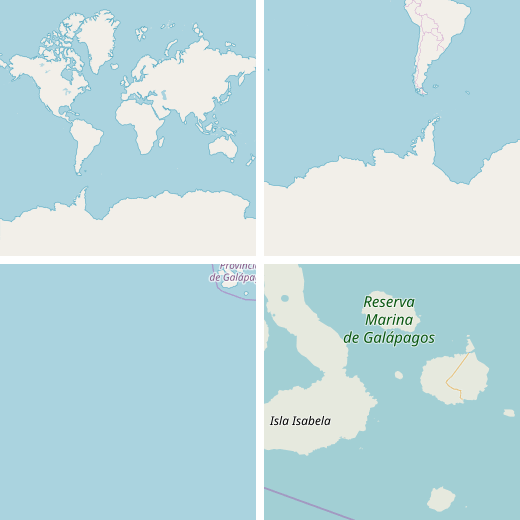

In [14]:
convert_pil(composite)

In [19]:
#XXX
def get_surrounding(x, y, z, tile_fun):
    composite = PIL.Image.new('RGBA', (768, 768))
    for xi, x_ in enumerate([x - 1, x, x + 1]):
        for yi, y_ in enumerate([y - 1, y, y + 1]):
            tile_req = tile_fun(x_, y_, z)
            pos = (xi * 256, yi * 256, xi * 256 + 256, yi * 256 + 256)
            img = PIL.Image.open(BytesIO(tile_req.content))
            composite.paste(img, pos)
    return composite

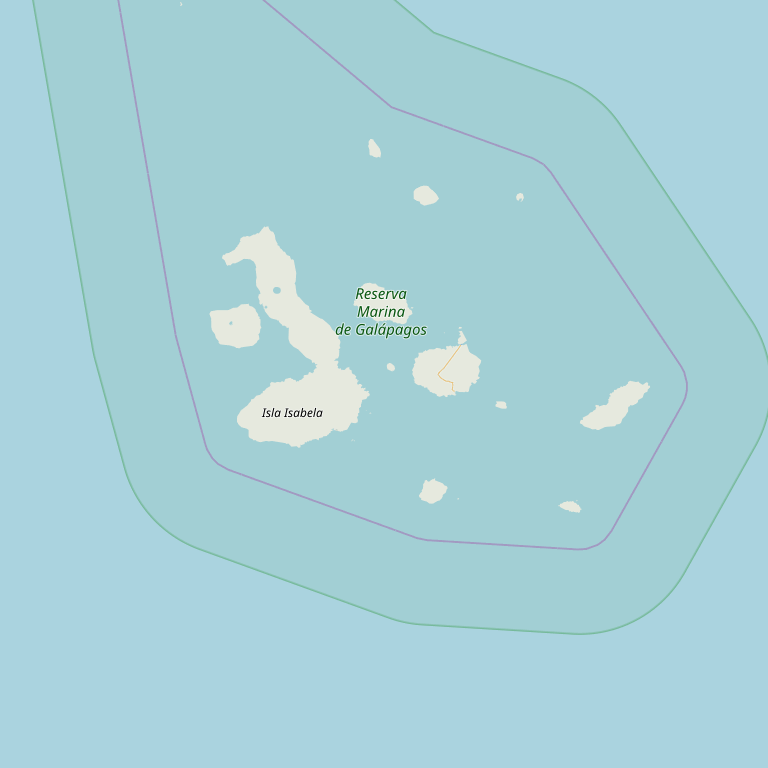

In [18]:
zoom = 8
x, y = deg_xy(lat, lon, zoom)
osm_big = get_surrounding(x, y, zoom, get_osm_tile)
convert_pil(osm_big)

In [20]:
def get_gbif_tile(x, y, z, **kwargs):
    server = 'http://api.gbif.org/v1'
    kwargs['x'] = str(x)
    kwargs['y'] = str(y)
    kwargs['z'] = str(z)
    req = requests.get('%s/map/density/tile' % server,
                       params=kwargs,
                       headers={})
    if not req.ok:
        req.raise_for_status()
    return req

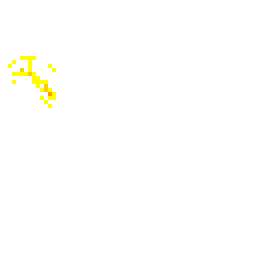

In [22]:
gbif_tile = get_gbif_tile(0, 0, 0, resolution='4',
                       type='TAXON', key='6163845')
#do wee need to add copyright? (both osm and gbif)
img = PIL.Image.open(BytesIO(gbif_tile.content))
convert_pil(img)

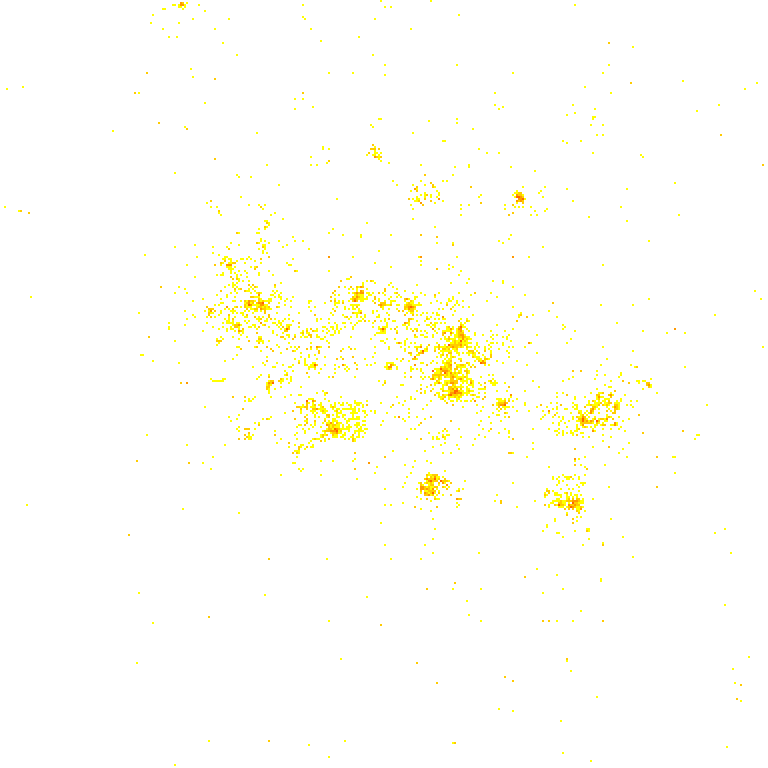

In [23]:
import functools
zoom = 8
x, y = deg_xy(lat, lon, zoom)
gbif_big = get_surrounding(x, y, zoom,
                           functools.partial(get_gbif_tile, hue='0.1',
                                             resolution='2',
                                             saturation='True'))
convert_pil(gbif_big)

In [24]:
compose = PIL.Image.alpha_composite(osm_big, gbif_big)

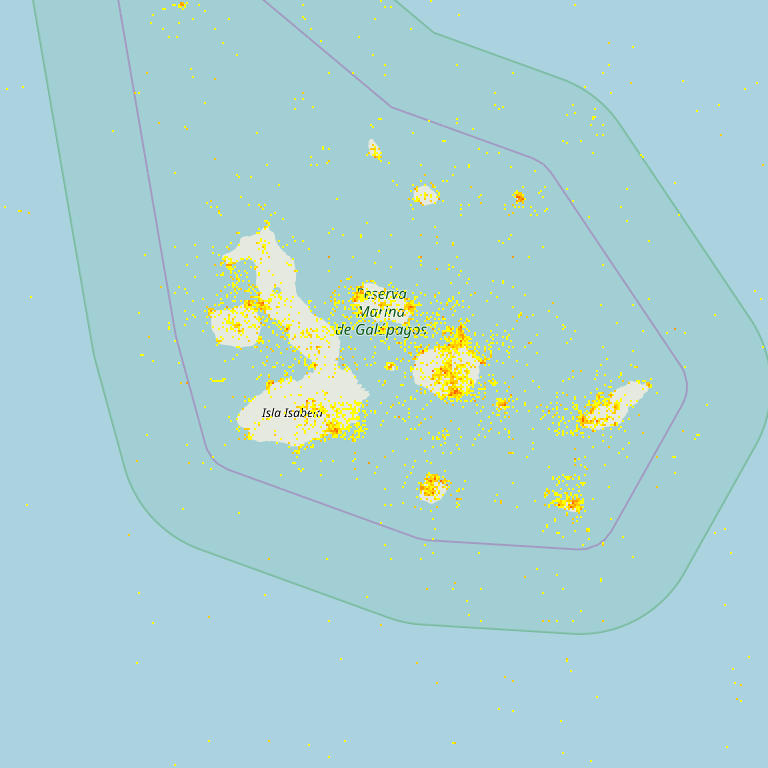

In [25]:
convert_pil(compose)

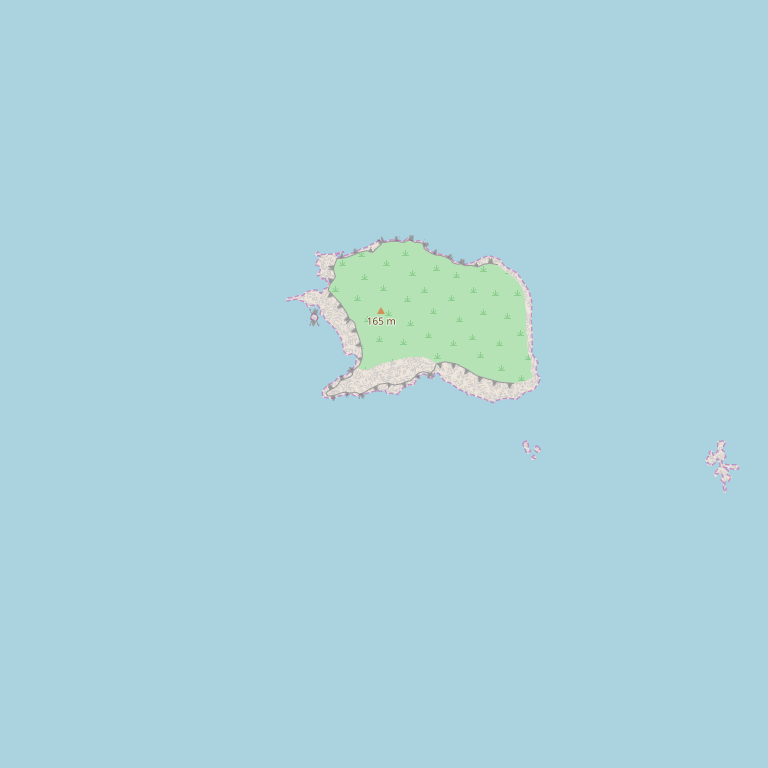

In [26]:
#not on recipe
zoom = 15
x, y = deg_xy(1.6783, -92.0012, zoom)
osm_tile = get_osm_tile(x, y, zoom)
darwin_big = get_surrounding(x, y, zoom, get_osm_tile)
convert_pil(darwin_big)

In [27]:
def do_request(service, a1=None, a2=None, a3=None, **kwargs):
    server = 'http://api.gbif.org/v1'
    params = ''
    for a in [a1, a2, a3]:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
    if not req.ok:
        req.raise_for_status()
    return req.json()


def get_all_records(rec_field, service, a1=None, a2=None, a3=None, **kwargs):
    records = []
    all_done = False
    offset = 0
    num_iter = 0
    while not all_done and num_iter < 100:
        req = do_request(service, a1=a1, a2=a2, a3=a3, offset=offset, **kwargs)
        all_done = req['endOfRecords']
        offset += req['limit']
        records.extend(req[rec_field])
        num_iter += 1
    return records

#tighter polygon coordinates
start = 2, -93
end = 1, -91
geom = 'POLYGON(({xi} {yi}, {xf} {yi}, {xf} {yf}, {xi} {yf}, {xi} {yi}))'.format(
    xi=start[1], xf=end[1], yi=start[0], yf=end[0])
print(geom)
recs = get_all_records('results', 'occurrence', 'search', geometry=geom)

POLYGON((-93 2, -91 2, -91 1, -93 1, -93 2))


In [28]:
recs[0]

{'key': 1836639251,
 'datasetKey': '50c9509d-22c7-4a22-a47d-8c48425ef4a7',
 'publishingOrgKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
 'networkKeys': [],
 'installationKey': '997448a8-f762-11e1-a439-00145eb45e9a',
 'publishingCountry': 'US',
 'protocol': 'DWC_ARCHIVE',
 'lastCrawled': '2018-09-03T09:29:40.128+0000',
 'lastParsed': '2018-05-09T01:50:57.069+0000',
 'crawlId': 124,
 'extensions': {},
 'basisOfRecord': 'HUMAN_OBSERVATION',
 'taxonKey': 9461162,
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 1493,
 'familyKey': 9342,
 'genusKey': 9768610,
 'speciesKey': 9461162,
 'scientificName': 'Zapornia paykullii',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Gruiformes',
 'family': 'Rallidae',
 'genus': 'Zapornia',
 'species': 'Zapornia paykullii',
 'genericName': 'Zapornia',
 'specificEpithet': 'paykullii',
 'taxonRank': 'SPECIES',
 'dateIdentified': '2018-03-16T15:11:09.000+0000',
 'decimalLongitude': 103.810275,
 'decimalLatitude': 1.290292,
 'coor